# Cold Season


Import


In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


loading data


In [2]:
# Load data
data = pd.read_csv("cold_season_NITJ_data.csv")

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Sort data by Date
data.sort_values(by='Date', inplace=True)

Feature Selection and scaling

In [3]:
# Feature selection
features = ['Temperature', 'Pressure', 'Relative Humidity', 'Solar Zenith Angle', 'Wind Speed', 'Wind Direction', 'Dew Point', 'Precipitable Water', 'Clearness Index']

# Target variable
target = ['GHI']

# Select features and target
X = data[features].values
Y = data[target].values

# Scale features and target
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)


Reshaping Data for LSTM

In [6]:
# Define window size for time series data
window_size = 24


X_lstm, Y_lstm = [], []
for i in range(len(X_scaled) - window_size):
    X_lstm.append(X_scaled[i:i + window_size])
    Y_lstm.append(Y_scaled[i + window_size])

X_lstm, Y_lstm = np.array(X_lstm), np.array(Y_lstm)


Splitting  Data into Train, Validation, and Test Sets

In [7]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_lstm, Y_lstm, test_size=0.2, random_state=42)

# Further split training data into training and validation sets (70% train, 30% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)


Defining LSTM

In [8]:
# Define LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])


Training


In [12]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/40
414/414 [==============================] - 17s 33ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 2/40
414/414 [==============================] - 12s 30ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 3/40
414/414 [==============================] - 12s 30ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 4/40
414/414 [==============================] - 12s 30ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 5/40
414/414 [==============================] - 13s 32ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 6/40
414/414 [==============================] - 12s 30ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 7/40
414/414 [==============================] - 13s 32ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 8/40
414/414 [==============================] - 11s 27ms/step - loss: 0.0043 - val_loss: 0.0039


Plot Training and validation loss


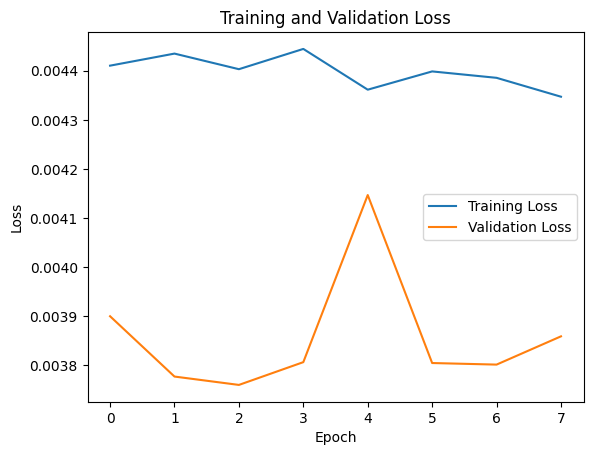

In [13]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Evaluate and making predictions

In [14]:
# Evaluate model
train_loss = model.evaluate(X_train, Y_train, verbose=0)
val_loss = model.evaluate(X_val, Y_val, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"Train Loss: {train_loss:.5f}")
print(f"Validation Loss: {val_loss:.5f}")
print(f"Test Loss: {test_loss:.5f}")

# Make predictions
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)
Y_test_pred = model.predict(X_test)


Train Loss: 0.00373
Validation Loss: 0.00376
Test Loss: 0.00368
148/148 [==============================] - 1s 8ms/step


Inverse Scaling and calculate metrics

In [21]:
# Inverse scaling
Y_train_pred_inv = scaler_Y.inverse_transform(Y_train_pred)
Y_val_pred_inv = scaler_Y.inverse_transform(Y_val_pred)
Y_test_pred_inv = scaler_Y.inverse_transform(Y_test_pred)
Y_train_true_inv = scaler_Y.inverse_transform(Y_train)
Y_val_true_inv = scaler_Y.inverse_transform(Y_val)
Y_test_true_inv = scaler_Y.inverse_transform(Y_test)

# Calculate metrics
def calculate_metrics(Y_true, Y_pred):
    r2 = r2_score(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mse = mean_squared_error(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    return r2, rmse, mse, mae

train_r2, train_rmse, train_mse, train_mae = calculate_metrics(Y_train_true_inv, Y_train_pred_inv)
val_r2, val_rmse, val_mse, val_mae = calculate_metrics(Y_val_true_inv, Y_val_pred_inv)
test_r2, test_rmse, test_mse, test_mae = calculate_metrics(Y_test_true_inv, Y_test_pred_inv)


Metrics

In [22]:
# Print metrics
print("Training set metrics:")
print(f"R^2: {train_r2:.5f}")
print(f"RMSE: {train_rmse:.5f}")
print(f"MSE: {train_mse:.5f}")
print(f"MAE: {train_mae:.5f}")
print()
print("Validation set metrics:")
print(f"R^2: {val_r2:.5f}")
print(f"RMSE: {val_rmse:.5f}")
print(f"MSE: {val_mse:.5f}")
print(f"MAE: {val_mae:.5f}")
print()
print("Test set metrics:")
print(f"R^2: {test_r2:.5f}")
print(f"RMSE: {test_rmse:.5f}")
print(f"MSE: {test_mse:.5f}")
print(f"MAE: {test_mae:.5f}")


Training set metrics:
R^2: 0.94057
RMSE: 57.04380
MSE: 3253.99496
MAE: 33.01067

Validation set metrics:
R^2: 0.93927
RMSE: 57.27336
MSE: 3280.23774
MAE: 33.98434

Test set metrics:
R^2: 0.94253
RMSE: 56.68928
MSE: 3213.67499
MAE: 33.37367


Ploting predictions


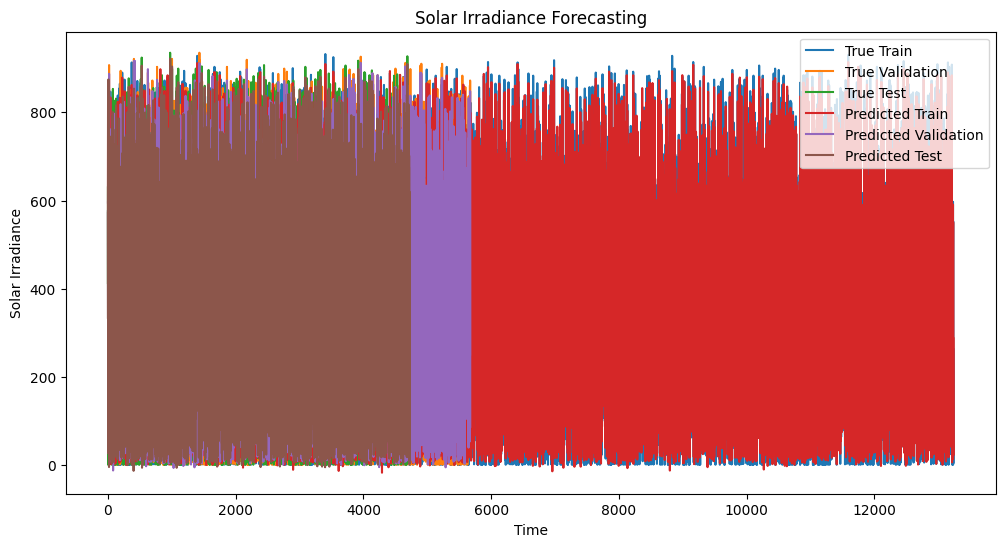

In [23]:
# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(Y_train_true_inv, label='True Train')
plt.plot(Y_val_true_inv, label='True Validation')
plt.plot(Y_test_true_inv, label='True Test')
plt.plot(Y_train_pred_inv, label='Predicted Train')
plt.plot(Y_val_pred_inv, label='Predicted Validation')
plt.plot(Y_test_pred_inv, label='Predicted Test')
plt.title('Solar Irradiance Forecasting')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance')
plt.legend()
plt.show()


# Monsoon Season


loading data


In [26]:
# Load data
data = pd.read_csv("monsoon_season_NITJ_data.csv")

# print(data['Date'].head())

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')

# Sort data by Date
data.sort_values(by='Date', inplace=True)

Feature Selection and scaling

In [27]:
# Feature selection
features = ['Temperature', 'Pressure', 'Relative Humidity', 'Solar Zenith Angle', 'Wind Speed', 'Wind Direction', 'Dew Point', 'Precipitable Water', 'Clearness Index']

# Target variable
target = ['GHI']

# Select features and target
X = data[features].values
Y = data[target].values

# Scale features and target
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)


Reshaping data

In [28]:
# Define window size for time series data
window_size = 24


X_lstm, Y_lstm = [], []
for i in range(len(X_scaled) - window_size):
    X_lstm.append(X_scaled[i:i + window_size])
    Y_lstm.append(Y_scaled[i + window_size])

X_lstm, Y_lstm = np.array(X_lstm), np.array(Y_lstm)


Splitting data into training , validation and testing

In [29]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_lstm, Y_lstm, test_size=0.2, random_state=42)

# Further split training data into training and validation sets (70% train, 30% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)



Defining LSTM

In [30]:
# Define LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])


Training

In [31]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/40
309/309 [==============================] - 16s 36ms/step - loss: 0.0502 - val_loss: 0.0215
Epoch 2/40
309/309 [==============================] - 8s 27ms/step - loss: 0.0214 - val_loss: 0.0157
Epoch 3/40
309/309 [==============================] - 10s 32ms/step - loss: 0.0182 - val_loss: 0.0142
Epoch 4/40
309/309 [==============================] - 10s 32ms/step - loss: 0.0163 - val_loss: 0.0131
Epoch 5/40
309/309 [==============================] - 8s 27ms/step - loss: 0.0155 - val_loss: 0.0138
Epoch 6/40
309/309 [==============================] - 10s 32ms/step - loss: 0.0146 - val_loss: 0.0118
Epoch 7/40
309/309 [==============================] - 11s 36ms/step - loss: 0.0141 - val_loss: 0.0115
Epoch 8/40
309/309 [==============================] - 9s 28ms/step - loss: 0.0136 - val_loss: 0.0116
Epoch 9/40
309/309 [==============================] - 10s 31ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 10/40
309/309 [==============================] - 10s 33ms/step - loss: 0.0129 -

Plot training and validation loss

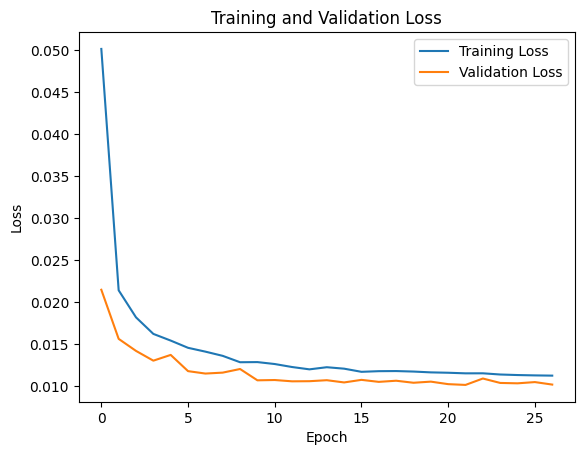

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Evaluate and make predications

In [33]:
# Evaluate model
train_loss = model.evaluate(X_train, Y_train, verbose=0)
val_loss = model.evaluate(X_val, Y_val, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"Train Loss: {train_loss:.5f}")
print(f"Validation Loss: {val_loss:.5f}")
print(f"Test Loss: {test_loss:.5f}")

# Make predictions
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)
Y_test_pred = model.predict(X_test)


Train Loss: 0.01009
Validation Loss: 0.01019
Test Loss: 0.01077
111/111 [==============================] - 1s 8ms/step


Inverse scaling and calculate metrics

In [35]:
# Inverse scaling
Y_train_pred_inv = scaler_Y.inverse_transform(Y_train_pred)
Y_val_pred_inv = scaler_Y.inverse_transform(Y_val_pred)
Y_test_pred_inv = scaler_Y.inverse_transform(Y_test_pred)
Y_train_true_inv = scaler_Y.inverse_transform(Y_train)
Y_val_true_inv = scaler_Y.inverse_transform(Y_val)
Y_test_true_inv = scaler_Y.inverse_transform(Y_test)

# Calculate metrics
def calculate_metrics(Y_true, Y_pred):
    r2 = r2_score(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mse = mean_squared_error(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    return r2, rmse, mse, mae

train_r2, train_rmse, train_mse, train_mae = calculate_metrics(Y_train_true_inv, Y_train_pred_inv)
val_r2, val_rmse, val_mse, val_mae = calculate_metrics(Y_val_true_inv, Y_val_pred_inv)
test_r2, test_rmse, test_mse, test_mae = calculate_metrics(Y_test_true_inv, Y_test_pred_inv)

# Print metrics
print("Training set metrics:")
print(f"R^2: {train_r2:.5f}")
print(f"RMSE: {train_rmse:.5f}")
print(f"MSE: {train_mse:.5f}")
print(f"MAE: {train_mae:.5f}")
print()
print("Validation set metrics:")
print(f"R^2: {val_r2:.5f}")
print(f"RMSE: {val_rmse:.5f}")
print(f"MSE: {val_mse:.5f}")
print(f"MAE: {val_mae:.5f}")
print()
print("Test set metrics:")
print(f"R^2: {test_r2:.5f}")
print(f"RMSE: {test_rmse:.5f}")
print(f"MSE: {test_mse:.5f}")
print(f"MAE: {test_mae:.5f}")

Training set metrics:
R^2: 0.88814
RMSE: 92.80586
MSE: 8612.92797
MAE: 56.52969

Validation set metrics:
R^2: 0.88757
RMSE: 93.25885
MSE: 8697.21358
MAE: 56.90175

Test set metrics:
R^2: 0.88499
RMSE: 95.89659
MSE: 9196.15643
MAE: 58.38278


Ploting predictions


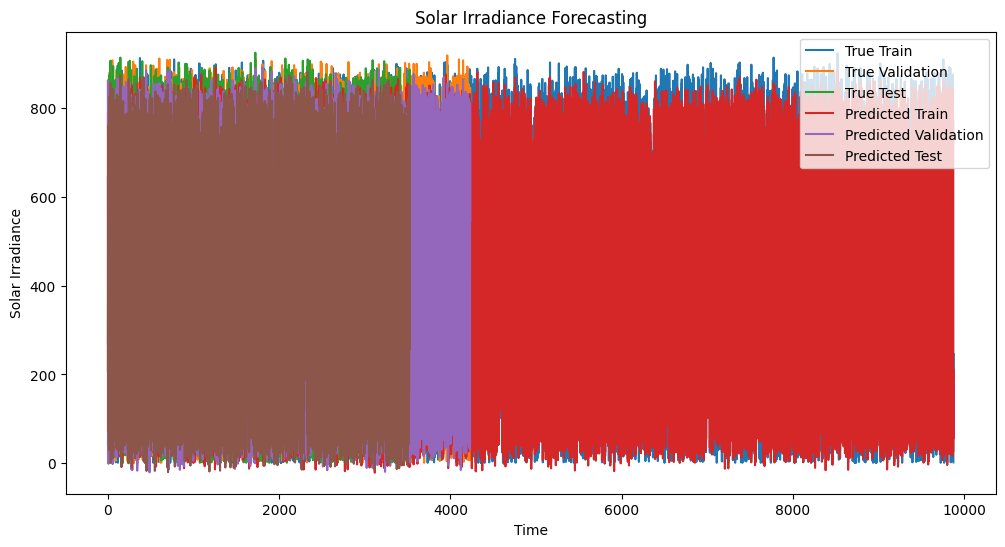

In [36]:
# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(Y_train_true_inv, label='True Train')
plt.plot(Y_val_true_inv, label='True Validation')
plt.plot(Y_test_true_inv, label='True Test')
plt.plot(Y_train_pred_inv, label='Predicted Train')
plt.plot(Y_val_pred_inv, label='Predicted Validation')
plt.plot(Y_test_pred_inv, label='Predicted Test')
plt.title('Solar Irradiance Forecasting')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance')
plt.legend()
plt.show()

# Post-Monsoon

loading data


In [37]:
# Load data
data = pd.read_csv("post_monsoon_NITJ_data.csv")

# print(data['Date'].head())

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')

# Sort data by Date
data.sort_values(by='Date', inplace=True)

Feature selection and scaling

In [38]:
# Feature selection
features = ['Temperature', 'Pressure', 'Relative Humidity', 'Solar Zenith Angle', 'Wind Speed', 'Wind Direction', 'Dew Point', 'Precipitable Water', 'Clearness Index']

# Target variable
target = ['GHI']

# Select features and target
X = data[features].values
Y = data[target].values

# Scale features and target
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)


Reshaping data

In [39]:
# Define window size for time series data
window_size = 24


X_lstm, Y_lstm = [], []
for i in range(len(X_scaled) - window_size):
    X_lstm.append(X_scaled[i:i + window_size])
    Y_lstm.append(Y_scaled[i + window_size])

X_lstm, Y_lstm = np.array(X_lstm), np.array(Y_lstm)

Splitting data into training, validating, and testing data

In [40]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_lstm, Y_lstm, test_size=0.2, random_state=42)

# Further split training data into training and validation sets (70% train, 30% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)


Defining LSTm


In [41]:
# Define LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])


Training

In [43]:
 #Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/40
90/90 [==============================] - 8s 53ms/step - loss: 0.0743 - val_loss: 0.0272
Epoch 2/40
90/90 [==============================] - 2s 27ms/step - loss: 0.0226 - val_loss: 0.0120
Epoch 3/40
90/90 [==============================] - 2s 27ms/step - loss: 0.0140 - val_loss: 0.0087
Epoch 4/40
90/90 [==============================] - 2s 27ms/step - loss: 0.0116 - val_loss: 0.0079
Epoch 5/40
90/90 [==============================] - 2s 27ms/step - loss: 0.0104 - val_loss: 0.0068
Epoch 6/40
90/90 [==============================] - 4s 46ms/step - loss: 0.0096 - val_loss: 0.0066
Epoch 7/40
90/90 [==============================] - 2s 27ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 8/40
90/90 [==============================] - 2s 27ms/step - loss: 0.0091 - val_loss: 0.0059
Epoch 9/40
90/90 [==============================] - 2s 27ms/step - loss: 0.0085 - val_loss: 0.0065
Epoch 10/40
90/90 [==============================] - 2s 27ms/step - loss: 0.0084 - val_loss: 0.0058
Epoch 11/

Evaluate and making predictions

In [ ]:
# Evaluate model
train_loss = model.evaluate(X_train, Y_train, verbose=0)
val_loss = model.evaluate(X_val, Y_val, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"Train Loss: {train_loss:.5f}")
print(f"Validation Loss: {val_loss:.5f}")
print(f"Test Loss: {test_loss:.5f}")

# Make predictions
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)
Y_test_pred = model.predict(X_test)

Plot training and validation loss

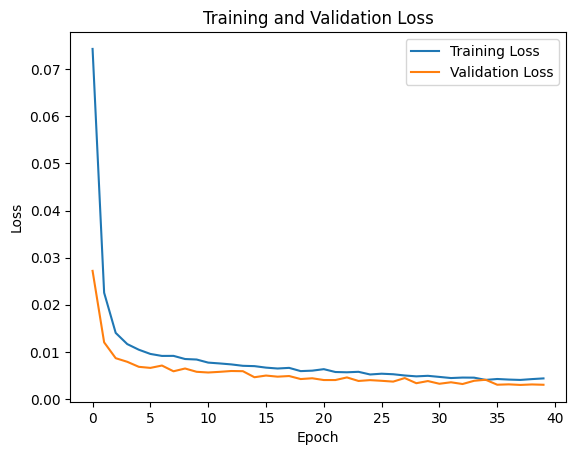

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Inverse scaling and calculate metrics


In [ ]:
# Inverse scaling
Y_train_pred_inv = scaler_Y.inverse_transform(Y_train_pred)
Y_val_pred_inv = scaler_Y.inverse_transform(Y_val_pred)
Y_test_pred_inv = scaler_Y.inverse_transform(Y_test_pred)
Y_train_true_inv = scaler_Y.inverse_transform(Y_train)
Y_val_true_inv = scaler_Y.inverse_transform(Y_val)
Y_test_true_inv = scaler_Y.inverse_transform(Y_test)

# Calculate metrics
def calculate_metrics(Y_true, Y_pred):
    r2 = r2_score(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mse = mean_squared_error(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    return r2, rmse, mse, mae

train_r2, train_rmse, train_mse, train_mae = calculate_metrics(Y_train_true_inv, Y_train_pred_inv)
val_r2, val_rmse, val_mse, val_mae = calculate_metrics(Y_val_true_inv, Y_val_pred_inv)
test_r2, test_rmse, test_mse, test_mae = calculate_metrics(Y_test_true_inv, Y_test_pred_inv)

# Print metrics
print("Training set metrics:")
print(f"R^2: {train_r2:.5f}")
print(f"RMSE: {train_rmse:.5f}")
print(f"MSE: {train_mse:.5f}")
print(f"MAE: {train_mae:.5f}")
print()
print("Validation set metrics:")
print(f"R^2: {val_r2:.5f}")
print(f"RMSE: {val_rmse:.5f}")
print(f"MSE: {val_mse:.5f}")
print(f"MAE: {val_mae:.5f}")
print()
print("Test set metrics:")
print(f"R^2: {test_r2:.5f}")
print(f"RMSE: {test_rmse:.5f}")
print(f"MSE: {test_mse:.5f}")
print(f"MAE: {test_mae:.5f}")